In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import os
import glob
import re
# import cv2
import math
from natsort import natsorted
# from tqdm import tqdm
IMAGE_DATASETS = ['quickdraw', 'fashion']

In [2]:
dataset_id = ''

In [3]:
dataset_id = 'gaussians_'
os.chdir('..')

In [4]:
# !pwd

In [5]:
projection_paths = pd.read_csv('metrics/results/{}.csv'.format(dataset_id), index_col=0).index
names = projection_paths.str.extract(r'.*/{}-(.*).csv'.format(dataset_id), expand=False) # Clean string

In [6]:
dataset_path = '../datasets/' + dataset_id + '/'
projection_paths = ['./output/' + p for p in projection_paths]

print(projection_paths, dataset_id)

['./output//gaussians-cumap.csv'] gaussians_


In [7]:
# !mkdir {'Plots/Anim/'+dataset_id}

In [8]:
def get_projection_as_array(dataset_path):
    print(dataset_path)
    df = pd.read_csv(dataset_path, index_col=0)
    vs = df.values.reshape(len(df), -1, 2)
    return vs, df.index, vs.shape[1]


def get_md_mov(dataset_path):
    vs, indexes, n_timesteps = get_projection_as_array(dataset_path)
    mov = []
    for poly in vs:
        mov_i = []
        for i in range(len(poly)-1):
            mov_i.append(math.sqrt(np.sum(np.square(poly[i] - poly[i+1]))))
        mov.append(np.array(mov_i))
    return np.array(mov), indexes, n_timesteps


# get_md_mov('./Output/quickdraw-pca_s4.csv')

In [9]:
def image_dataset_to_array(dataset_path):
    # Convert image to np array
    # Preload images to memory (trying to speed things up)
    all_files = glob.glob('{}*'.format(dataset_path))
    # Gather ids and timestep info    
    max_t = {}
    for f in all_files:
        regex = r".*/{}/(.*-.*)-(.*).png".format(dataset_id)
        match = re.match(regex, f)
        img_id, t = match.groups()
        t = int(t)
        max_t[img_id] = max_t[img_id] if img_id in max_t and max_t[img_id] > t else t   
    
    img_size = 28 * 28  # Pixel count
    n_revisions = max(max_t.values()) + 1
    n_items = len(max_t.values())
    vs = np.empty((n_revisions, n_items, img_size))
    
    # Populate vs
    for i, img_id in enumerate(natsorted(max_t)):
        # Copy existing bitmaps to np.array
        for t in range(0, max_t[img_id]):
            img_file = dataset_path + img_id + '-' + str(t) + '.png'
            vs[t][i] = (cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) / 255.).flatten()
        # Replicate last image
        for t in range(max_t[img_id], n_revisions):
            img_file = dataset_path + img_id + '-' + str(max_t[img_id]-1) + '.png'
            vs[t][i] = (cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) / 255.).flatten()    
    return vs, list(natsorted(max_t)), n_revisions


def tabular_dataset_to_array(dataset_path):
    # Get files with coords and save in an array vs
    all_files = natsorted(glob.glob('{}*'.format(dataset_path)))
    vs = [pd.read_csv(f, index_col=0).values for f in all_files] 
    # Get dataset info 
    df_temp = pd.read_csv(all_files[0], index_col=0)
    n_timesteps = len(all_files)
    return np.array(vs), list(df_temp.index), n_timesteps


def dataset_as_array(dataset_path):
    if dataset_id in IMAGE_DATASETS:
         return image_dataset_to_array(dataset_path)
    else:
        return tabular_dataset_to_array(dataset_path)


def get_nd_mov(dataset_id):
    mov = []
    dataset_path = './datasets/' + dataset_id + '/'
    # Get the nd data into arrays
    vs, indexes, n_timesteps = dataset_as_array(dataset_path)
    # Compute dists between 2 nd arrays
    for t in range(n_timesteps - 1):
        v_t = vs[t]
        v_tp1 = vs[t+1]
        mov_t = []
        for a, b in zip(v_t, v_tp1):
            mov_t.append(math.sqrt(np.sum(np.square(a - b))))
        mov.append(np.array(mov_t)) 
    return np.array(mov).T, indexes, n_timesteps

# dists, indexes, n_timesteps = get_nd_dists('quickdraw')

In [13]:
lims = {}
pos_interp = {}
indexes = {}
colors = {}
for p_i, p in enumerate(projection_paths):
    pos, ind, n_timesteps = get_projection_as_array(p)
    # Shuffle arrays
    perm = np.random.permutation(len(ind))
    pos = pos[perm]
    indexes[p] = ind[perm]

    # Set x and y axis limits
    x_max = max(pos[:,:,0].flatten())
    x_min = min(pos[:,:,0].flatten())
    y_max = max(pos[:,:,1].flatten())
    y_min = min(pos[:,:,1].flatten())
    x_max = x_max + (x_max - x_min) * .03
    x_min = x_min - (x_max - x_min) * .03
    y_max = y_max + (y_max - y_min) * .03
    y_min = y_min - (y_max - y_min) * .03
    lims[p] = (x_min, x_max, y_min, y_max)

    # Choose colors
    colormap = matplotlib.cm.Set3
    classes = indexes[p].str.split('-').str[0]
    unique_colors = {k:i for i,k in enumerate(np.unique(classes))}
    colors[p] = [colormap(unique_colors[c]) for c in classes] 

    # Add more points with akima interpolation
    n_nans = 99
    pos_int = []
    for points in pos:
        extended = []
        for po in points:
            extended.append(list(po))
            for i in range(n_nans):
                extended.append([np.nan, np.nan])
        df = pd.DataFrame(extended)
        df = df.interpolate(method='akima')
        df = df.dropna()
        pos_int.append(df.values)
    pos_interp[p] = np.array(pos_int)
    n_extended = len(df)

./output//gaussians-cumap.csv


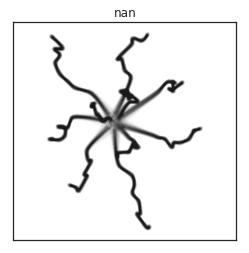

In [25]:
# anim_dir = 'Plots/Anim/{}'.format(dataset_id)
# Draw figures
n_proj = len(projection_paths)

t = n_extended - 1
fig_1, axes = plt.subplots(ncols=n_proj, nrows=1,figsize=(n_proj*4,4))

# axes[0].set_ylabel(dataset_id)
for p_i, p in enumerate(projection_paths):
    # Draw trails
    ax = axes#[p_i]
    ax.set_title(names[p_i])
    for i in range(len(indexes[p])):
        e_trail = t + 1
        points = pos_interp[p][i,:e_trail]
        ax.plot(points[:,0], points[:,1], 
                c='k', lw=2, alpha=.01);
    # Draw scatter
#     ax.scatter(pos_interp[p][:,t,0], pos_interp[p][:,t,1], 
#                edgecolors='#000000', s=15, c=colors[p], alpha=1, zorder=4);

    ax.tick_params(axis='both', which='both', bottom=False, top=False,
                   labelbottom=False, right=False, left=False, labelleft=False)
    ax.set_xlim(lims[p][0], lims[p][1])
    ax.set_ylim(lims[p][2], lims[p][3])
#     break
    plt.axis('equal')

# Save current frame
#     plt.savefig('{}/proj-{}.png'.format(anim_dir, t),
#                 format='png', dpi=80, bbox_inches='tight')
plt.show()
# plt.clf()
# plt.close()
# fig_1.savefig('fig_1.png', bbox_inches='tight', pad_inches=0.1)

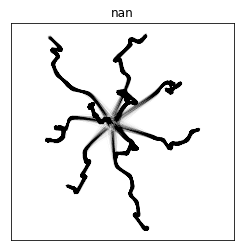

In [15]:
# anim_dir = 'Plots/Anim/{}'.format(dataset_id)
# Draw figures
n_proj = len(projection_paths)

t = n_extended - 1
fig_1, axes = plt.subplots(ncols=n_proj, nrows=1,figsize=(n_proj*4,4))
ax= axes
# axes[0].set_ylabel(dataset_id)
for p_i, p in enumerate(projection_paths):
    # Draw trails
#     ax = axes[p_i]
    ax.set_title(names[p_i])

    # Draw scatter
    ax.scatter(pos_interp[p][:,:,0], pos_interp[p][:,:,1], 
               edgecolors='#000000', s=1, c='k', alpha=.005, zorder=4);

    ax.tick_params(axis='both', which='both', bottom=False, top=False,
                   labelbottom=False, right=False, left=False, labelleft=False)
    ax.set_xlim(lims[p][0], lims[p][1])
    ax.set_ylim(lims[p][2], lims[p][3])
#     break
    plt.axis('equal')

# Save current frame
#     plt.savefig('{}/proj-{}.png'.format(anim_dir, t),
#                 format='png', dpi=80, bbox_inches='tight')
plt.show()
# plt.clf()
# plt.close()
# fig_1.savefig('fig_1.png', bbox_inches='tight', pad_inches=0.1)

In [16]:
x = pos_interp[p][:,:,0].flatten()
y = pos_interp[p][:,:,1].flatten()

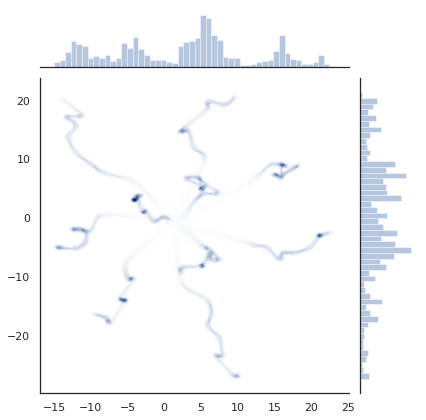

In [26]:
import numpy as np, pandas as pd; np.random.seed(0)
import seaborn as sns; sns.set(style="white", color_codes=True)

tips = sns.load_dataset("tips")
joint_kws=dict(gridsize=500)
g = sns.jointplot(x=x, y=y, kind="hex", joint_kws= joint_kws)

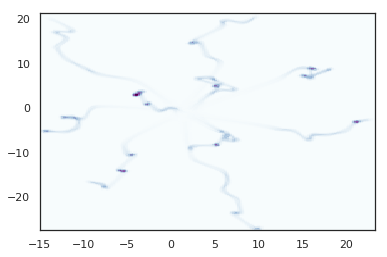

In [27]:
plt.hist2d(x, y, bins=(200, 200), cmap=plt.cm.BuPu);